# Leveraging the Apriori Algorithm for Market Basket Analysis: A Practical Approach to Boosting Sales
## Introduction
In the competitive world of retail, understanding customer buying behavior is crucial for optimizing sales strategies. 
Market basket analysis is a powerful data mining technique that helps retailers uncover associations between products purchased together. 
By identifying these relationships, businesses can optimize product placement, enhance cross-selling strategies, and tailor marketing efforts to boost sales. 
The code below illustrates how the Apriori algorithm can be used to identify frequently occurring itemsets in transactional data and solve real-world business challenges.

In [43]:
#Installing the necessary libraries
!pip install mlxtend
import pandas as pd
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime


[notice] A new release of pip is available: 23.2.1 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


## Setting the Stage: The Dataset

We began our journey with a dataset containing transactional data from a bakery based in Edinburgh. We did the necessary preprocessing and EDA (as seen in the subsections below) before proceeding with the implementation of the Apriori Algorithm.

### Initial Observations

This dataset has 20,507 rows and 5 columns: Transaction ID, the date and time of purchase, item names, and whether the purchase was made on a weekday or weekend. Its data from the year 2017.

The dataset contained duplicate rows, which we promptly in the steps below removed to ensure the accuracy of our

In [44]:
df= pd.read_csv('C:/Users/lkaur/Downloads/archive (1)/bread basket.csv')

In [45]:
df.shape
df.info()
df.head()
# Get min and max dates
min_date = df['date_time'].min()
max_date = df['date_time'].max()

print("Minimum date:", min_date)
print("Maximum date:", max_date)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20507 entries, 0 to 20506
Data columns (total 5 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Transaction      20507 non-null  int64 
 1   Item             20507 non-null  object
 2   date_time        20507 non-null  object
 3   period_day       20507 non-null  object
 4   weekday_weekend  20507 non-null  object
dtypes: int64(1), object(4)
memory usage: 801.2+ KB
Minimum date: 01-01-2017 01:21
Maximum date: 31-12-2016 17:36


In [46]:
#we see that there are a couple of duplicate rows here, lets check how many are there in the dataset
df.duplicated().sum()

1620

In [47]:
# Remove duplicates
df = df.drop_duplicates().reset_index(drop=True) #drop duplicates and reset the index

### Initial exploration of the data- Cross tables:

To analyze sales distribution across times and days, we used cross tables:  
Absolute Cross Table: Provided a view of total transactions by weekdays, weekends, and different day periods, identifying peak shopping times.  
Relative Cross Table: Normalized data to show the proportion of sales per period, revealing customer preferences.

**Findings**  
Afternoon Dominance: The afternoon is the peak shopping period on both weekdays and weekends, indicating a strong preference for shopping later in the day.  
Morning Activity: Mornings are the second busiest time, showing a trend of early shoppers.  
Low Evening and Night Activity: Shopping activity drops significantly in the evening and night, consistent across all days.

**Business Implication**   
Staffing and Inventory: Businesses might consider increasing staff and inventory during the afternoon and morning periods to accommodate higher purchase volumes.  
Promotions and Marketing: Targeting promotions and marketing efforts during these peak periods could be more effective.  
Operational Hours: Given the minimal activity at night, businesses might evaluate the necessity of extended operational hours.

In [48]:
# Cross table (absolute)
cross_table_absolute = pd.crosstab(df['weekday_weekend'], df['period_day'])
print("Cross table (absolute):")
print(cross_table_absolute)

# Cross table (relative)
cross_table_relative = pd.crosstab(df['weekday_weekend'], df['period_day'], normalize='index').round(3)
print("\nCross table (relative):")
print(cross_table_relative)


Cross table (absolute):
period_day       afternoon  evening  morning  night
weekday_weekend                                    
weekday               6742      336     4748      4
weekend               3945      154     2949      9

Cross table (relative):
period_day       afternoon  evening  morning  night
weekday_weekend                                    
weekday              0.570    0.028    0.401  0.000
weekend              0.559    0.022    0.418  0.001


### Understanding Customer Preferences Throughout the Day
We also wanted to get some insights into customer preferences at different times of the day. By grouping the data by item and period of the day, we identified the top 10 most popular items for each time period: morning, afternoon, evening, and night.  

**Findings**-  
Morning, Afternoon and Evening- customers predominantly favor traditional breakfast items like Coffee, Bread, Cake, Tea etc in the morning.    
These items are staples for a quick and energizing start to the day, reflecting the typical morning rush where customers seek convenience and comfort.
As the day progresses into the afternoon and evening, the preferences remain largely similar.  
This indicates that these items are not only popular for breakfast, but also serve as comforting treats for lunch and to wind down the day.  

Interestingly, the nighttime preferences show a distinct shift. The top orders at night include Vegan’s Feast, Valentine’s Card, Hot Chocolate. 
This change suggests that customers are looking for more indulgent and unique items as the day ends. The popularity of the Vegan’s Feast indicates a demand for healthier, plant-based options, while the Valentine’s Card and Hot Chocolate reflect a desire for special treats and perhaps a bit of late-night romance ❤️ or comfort.

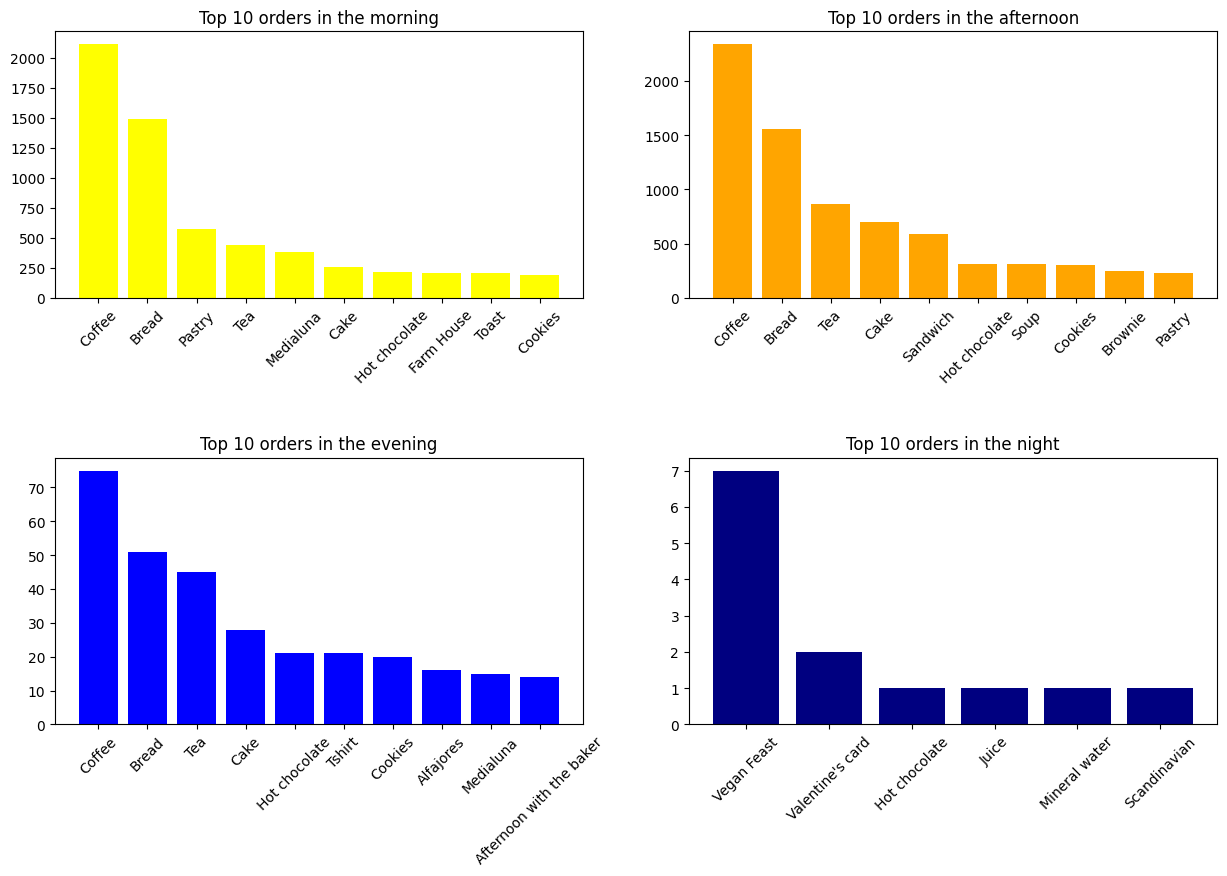

In [52]:
items = df.groupby(['Item', 'period_day'])['Transaction'].count().reset_index().sort_values(['period_day', 'Transaction'], ascending=False)

fig, axs = plt.subplots(2, 2, figsize=(15, 9))
plt.subplots_adjust(hspace=0.6)

# Define colors for each period of the day
colors = {
    'morning': 'yellow',
    'afternoon': 'orange',
    'evening': 'blue',
    'night': 'navy'
}

# Top 10 orders in the morning
dfMorning = items[items['period_day'] == 'morning'].head(10)
axs[0, 0].bar(dfMorning.Item, dfMorning.Transaction, color=colors['morning'])
axs[0, 0].set_title('Top 10 orders in the morning')
axs[0, 0].tick_params(axis='x', rotation=45)

# Top 10 orders in the afternoon
dfAfternoon = items[items['period_day'] == 'afternoon'].head(10)
axs[0, 1].bar(dfAfternoon.Item, dfAfternoon.Transaction, color=colors['afternoon'])
axs[0, 1].set_title('Top 10 orders in the afternoon')
axs[0, 1].tick_params(axis='x', rotation=45)

# Top 10 orders in the evening
dfEvening = items[items['period_day'] == 'evening'].head(10)
axs[1, 0].bar(dfEvening.Item, dfEvening.Transaction, color=colors['evening'])
axs[1, 0].set_title('Top 10 orders in the evening')
axs[1, 0].tick_params(axis='x', rotation=45)

# Top 10 orders in the night
dfNight = items[items['period_day'] == 'night'].head(10)
axs[1, 1].bar(dfNight.Item, dfNight.Transaction, color=colors['night'])
axs[1, 1].set_title('Top 10 orders in the night')
axs[1, 1].tick_params(axis='x', rotation=45)

plt.show()


### Understanding Item Popularity and Inventory Needs
Absolute Item Frequency  
We first counted the absolute frequency of each item, focusing on the top 25 items. This helps us identify which items are most frequently purchased.
This information is crucial for inventory management, as it highlights items that need to be stocked more frequently to meet customer demand.

Relative Item Frequency  
Next, we calculated the relative frequency of each item. This makes it easier to compare the popularity of items, especially when the total number of transactions varies. Relative frequency helps us understand the market share of each item within the dataset.

**Findings**  
Coffee is the most bought item, followed by Bread and Tea.

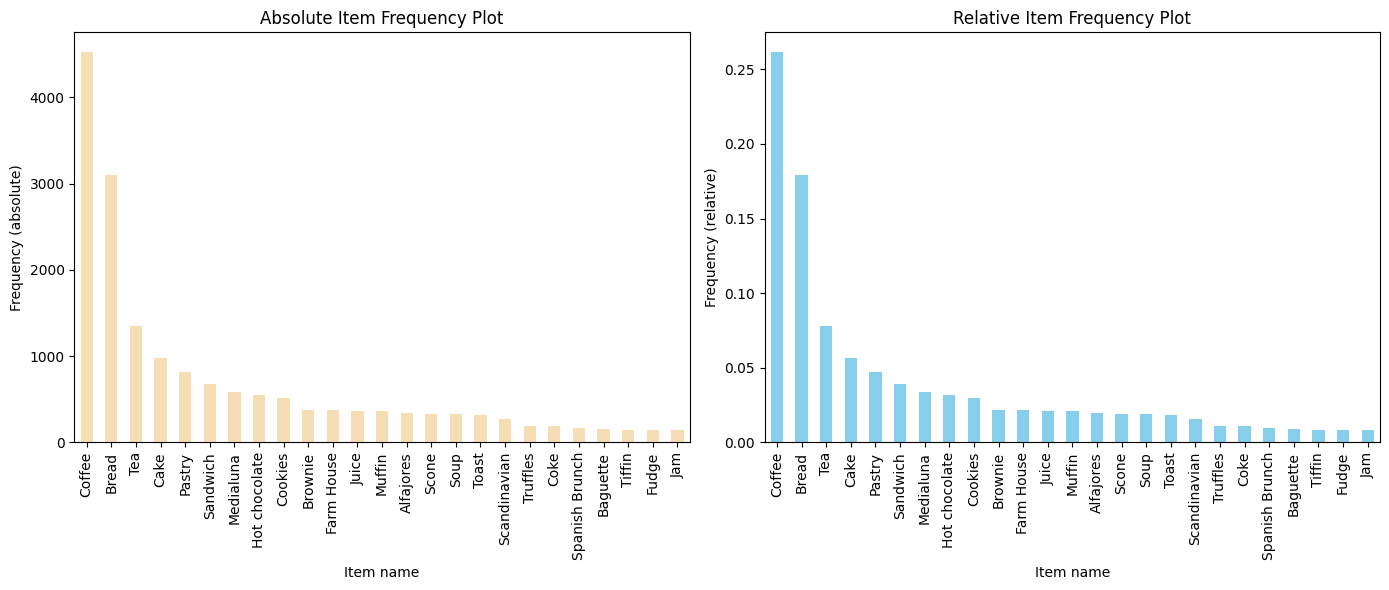

In [53]:
# Count the frequency of each item
item_counts = df['Item'].value_counts().head(25)  # Get the top 25 items

# Calculate relative frequencies
relative_frequencies = item_counts / item_counts.sum()

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Plot absolute item frequency
item_counts.plot(kind='bar', color='wheat', ax=axes[0])
axes[0].set_xlabel('Item name')
axes[0].set_ylabel('Frequency (absolute)')
axes[0].set_title('Absolute Item Frequency Plot')

# Plot relative item frequency
relative_frequencies.plot(kind='bar', color='skyblue', ax=axes[1])
axes[1].set_xlabel('Item name')
axes[1].set_ylabel('Frequency (relative)')
axes[1].set_title('Relative Item Frequency Plot')

plt.tight_layout()
plt.show()

### Patterns and Trends Over Different Time Periods
To better understand customer behavior, we analyzed transactions over various time periods. Here are the key findings:

**Findings**  
Seasonal Trends: The data shows distinct seasonal trends, with transaction peaks in November and early in the year, likely driven by holiday shopping and post-holiday sales. This insight is useful for identifying and preparing for seasonal demand fluctuations.

Average Transactions per Weekday: Weekends, particularly Saturdays, see the highest transaction volumes, while the beginning of the week tends to be slower. This information can help optimize staffing and promotional strategies.

Average Transactions per Hour: The majority of transactions occur during business hours, especially from late morning to early afternoon, indicating a preference for shopping during these times. This is crucial for effectively managing store operations and ensuring adequate staffing during peak periods.

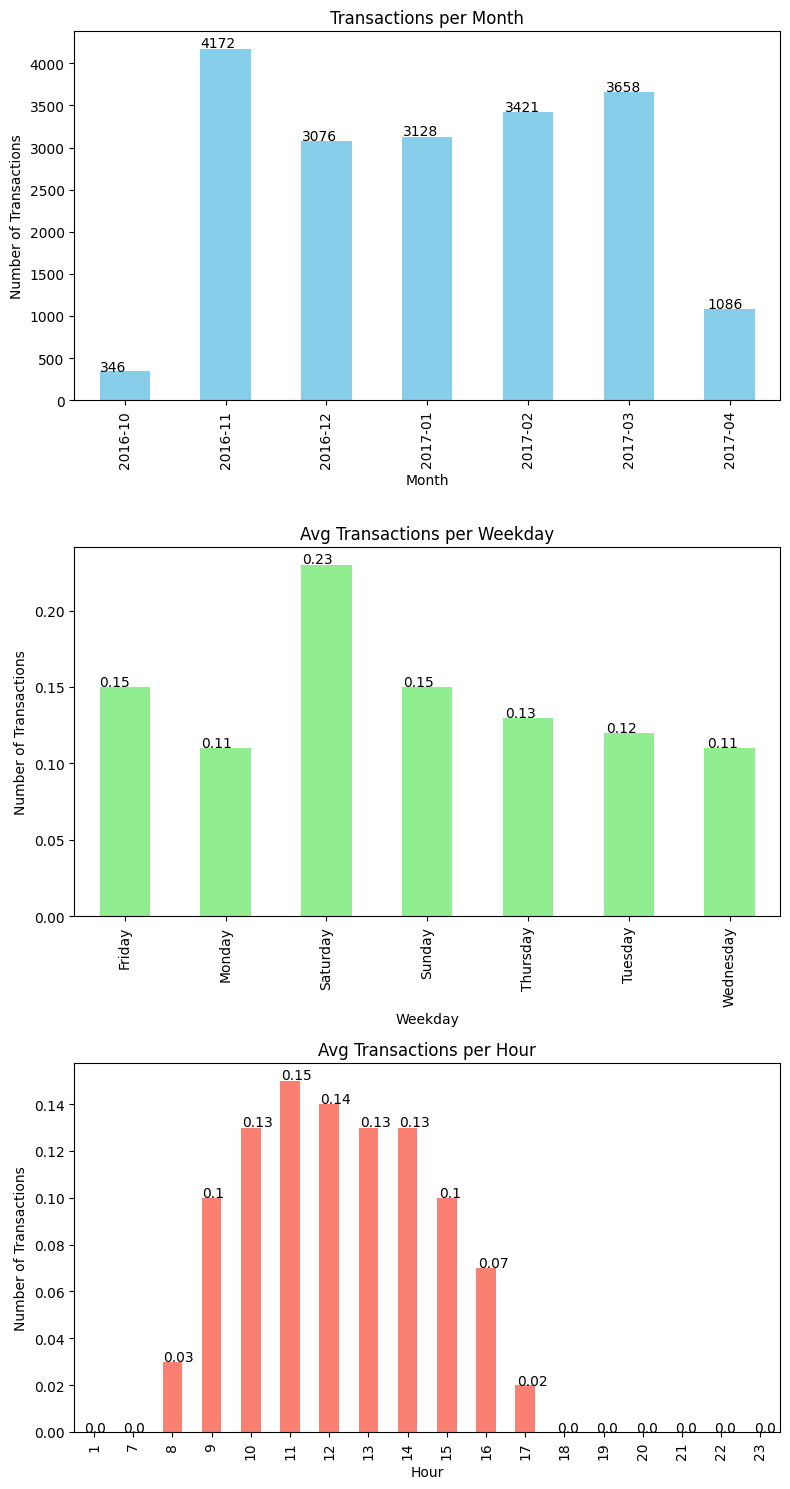

In [42]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 15))

# Plot transactions per month
transactions_per_month.plot(kind='bar', ax=axes[0], color='skyblue')
axes[0].set_title('Transactions per Month')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Number of Transactions')
for p in axes[0].patches:
    axes[0].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))

# Plot transactions per weekday
avg_transactions_per_weekday.plot(kind='bar', ax=axes[1], color='lightgreen')
axes[1].set_title('Avg Transactions per Weekday')
axes[1].set_xlabel('Weekday')
axes[1].set_ylabel('Number of Transactions')
for p in axes[1].patches:
    axes[1].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


# Plot transactions per hour
avg_transactions_per_hour.plot(kind='bar', ax=axes[2], color='salmon')
axes[2].set_title('Avg Transactions per Hour')
axes[2].set_xlabel('Hour')
axes[2].set_ylabel('Number of Transactions')
for p in axes[2].patches:
    axes[2].annotate(str(p.get_height()), (p.get_x() * 1.005, p.get_height() * 1.005))


plt.tight_layout()
plt.show()

## Apriori Algorithm:

The Apriori algorithm identifies frequent itemsets by iteratively exploring item combinations and evaluating their support values. By setting minimum support thresholds, we can filter out less significant itemsets and focus on those with the highest potential impact. 

### Data Transformation for Apriori:

Before diving into the analysis, it's crucial to transform our data into a format suitable for the Apriori algorithm. This step involves creating a "basket" representation of our transactional data, where each transaction is represented as a row, and each item is a column. The resulting matrix has binary values (0s and 1s), where 1 indicates the presence of an item in a transaction, and 0 indicates its absence.

In [18]:
# Convert the DataFrame to the required format for the Apriori algorithm
basket = df.groupby(['Transaction', 'Item']).size().unstack(fill_value=0)
basket = basket.applymap(lambda x: 1 if x > 0 else 0)
basket

C:\Users\lkaur\AppData\Local\Temp\ipykernel_19636\616742887.py:3: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  basket = basket.applymap(lambda x: 1 if x > 0 else 0)


Item,Adjustment,Afternoon with the baker,Alfajores,Argentina Night,Art Tray,Bacon,Baguette,Bakewell,Bare Popcorn,Basket,...,The BART,The Nomad,Tiffin,Toast,Truffles,Tshirt,Valentine's card,Vegan Feast,Vegan mincepie,Victorian Sponge
Transaction,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9680,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9681,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
9682,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


### Exploring Association Rules: Support and Confidence Analysis:  
We analyzed association rules by varying support levels from 10% to 0.5% and confidence thresholds from 90% to 10%. This helps identify frequent and reliable product associations.

**Understanding the Metrics:**  
Support measures how often an itemset appears in the dataset. Adjusting support levels helps determine how frequently items must occur together to be significant.
Confidence indicates the reliability of a rule, showing the likelihood of the consequent being purchased when the antecedent is bought. Higher confidence suggests stronger associations.

**Findings:**  
10% Support: Too few rules with low confidence; not representative.  
5% Support: Limited rules at reasonable confidence; need lower support.  
1% Support: Dozens of rules, with 13 having at least 50% confidence.  
0.5% Support: Too many rules to analyze effectively.  

**Conclusion:**  
We will use a support level of 1% and a confidence level of 50% to strike a balance between reliability and the number of rules.

In [19]:
# Support and confidence values
support_levels = [0.1, 0.05, 0.01, 0.005]
confidence_levels = [0.9, 0.8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2, 0.1]

# Initialize lists to store the number of rules
rules_sup10 = []
rules_sup5 = []
rules_sup1 = []
rules_sup0_5 = []

# Apriori algorithm with different support levels
for conf in confidence_levels:
    # Support level 10%
    frequent_itemsets = apriori(basket, min_support=support_levels[0], use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=conf)
    rules_sup10.append(len(rules))
    
    # Support level 5%
    frequent_itemsets = apriori(basket, min_support=support_levels[1], use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=conf)
    rules_sup5.append(len(rules))
    
    # Support level 1%
    frequent_itemsets = apriori(basket, min_support=support_levels[2], use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=conf)
    rules_sup1.append(len(rules))
    
    # Support level 0.5%
    frequent_itemsets = apriori(basket, min_support=support_levels[3], use_colnames=True)
    rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=conf)
    rules_sup0_5.append(len(rules))

print("Number of rules with support level 10%:", rules_sup10)
print("Number of rules with support level 5%:", rules_sup5)
print("Number of rules with support level 1%:", rules_sup1)
print("Number of rules with support level 0.5%:", rules_sup0_5)

# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

# Plot for support level 10%
sns.lineplot(x=confidence_levels, y=rules_sup10, marker='o', ax=axes[0, 0])
axes[0, 0].set_title('Apriori with a support level of 10%')
axes[0, 0].set_xlabel('Confidence level')
axes[0, 0].set_ylabel('Number of rules found')

# Plot for support level 5%
sns.lineplot(x=confidence_levels, y=rules_sup5, marker='o', ax=axes[0, 1])
axes[0, 1].set_title('Apriori with a support level of 5%')
axes[0, 1].set_xlabel('Confidence level')
axes[0, 1].set_ylabel('Number of rules found')
axes[0, 1].set_yticks(range(0, 11, 2))

# Plot for support level 1%
sns.lineplot(x=confidence_levels, y=rules_sup1, marker='o', ax=axes[1, 0])
axes[1, 0].set_title('Apriori with a support level of 1%')
axes[1, 0].set_xlabel('Confidence level')
axes[1, 0].set_ylabel('Number of rules found')
axes[1, 0].set_yticks(range(0, 51, 10))

# Plot for support level 0.5%
sns.lineplot(x=confidence_levels, y=rules_sup0_5, marker='o', ax=axes[1, 1])
axes[1, 1].set_title('Apriori with a support level of 0.5%')
axes[1, 1].set_xlabel('Confidence level')
axes[1, 1].set_ylabel('Number of rules found')
axes[1, 1].set_yticks(range(0, 131, 20))

plt.tight_layout()
plt.show()

C:\Users\lkaur\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\lkaur\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\lkaur\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(
C:\Users\lkaur\AppData\Local\Programs\Python\Pyth

Number of rules with support level 10%: [0, 0, 0, 0, 0, 0, 0, 0, 0]
Number of rules with support level 5%: [0, 0, 0, 0, 1, 1, 1, 2, 4]
Number of rules with support level 1%: [0, 0, 1, 1, 11, 16, 19, 31, 44]
Number of rules with support level 0.5%: [0, 1, 2, 4, 17, 25, 35, 57, 103]


### Interpreting Association Rules: Coffee Connections
In our analysis of association rules with a 1% support level and 50% confidence threshold, we uncovered intriguing patterns in customer purchasing behavior, particularly highlighting the prominence of coffee in transactions. 

**Key Findings from the rules generated**  
Hot Chocolate and Coffee: 51% of customers who purchased hot chocolate also bought coffee.  
Spanish Brunch and Coffee: 60% of customers who opted for a Spanish brunch also included coffee in their purchase.  
Toast and Coffee: A significant 70% of customers who bought toast also chose coffee.  

These patterns reveal the centrality of coffee in this bakery's offerings, highlighting its popularity among patrons. Understanding these associations can help the bakery optimize its product placement, promotions, and marketing strategies to capitalize on customers' affinity for coffee.

In [21]:
# Execute the Apriori algorithm with a support level of 1%
frequent_itemsets = apriori(basket, min_support=0.01, use_colnames=True)

# Generate association rules with a confidence level of 50%
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.5)

print("Association Rules:")
print(rules)

C:\Users\lkaur\AppData\Local\Programs\Python\Python312\Lib\site-packages\mlxtend\frequent_patterns\fpcommon.py:109: DeprecationWarning: DataFrames with non-bool types result in worse computationalperformance and their support might be discontinued in the future.Please use a DataFrame with bool type
  warnings.warn(


Association Rules:
         antecedents consequents  antecedent support  consequent support  \
0        (Alfajores)    (Coffee)            0.036344            0.478394   
1             (Cake)    (Coffee)            0.103856            0.478394   
2          (Cookies)    (Coffee)            0.054411            0.478394   
3    (Hot chocolate)    (Coffee)            0.058320            0.478394   
4            (Juice)    (Coffee)            0.038563            0.478394   
5        (Medialuna)    (Coffee)            0.061807            0.478394   
6           (Pastry)    (Coffee)            0.086107            0.478394   
7         (Sandwich)    (Coffee)            0.071844            0.478394   
8            (Scone)    (Coffee)            0.034548            0.478394   
9   (Spanish Brunch)    (Coffee)            0.018172            0.478394   
10           (Toast)    (Coffee)            0.033597            0.478394   

     support  confidence      lift  leverage  conviction  zhangs_met

### Making the rules from frequent itemset generated above
Using the lift metric with a minimum threshold of 1, we identified strong product associations, ensuring they reflect meaningful relationships rather than chance. Sorting these rules by confidence highlights reliable combinations, offering insights for effective bundling and cross-promotion strategies.

**Key Metrics and Insights:**  

Antecedents and Consequents: Items on the left (e.g., Toast) and right (e.g., Coffee) of the rule, respectively.  
Support: The proportion of transactions containing both items.  
Confidence: The likelihood of purchasing consequents when antecedents are bought.  
Lift: The strength of association compared to random occurrence; values greater than 1 suggest a positive association.  
Leverage and Conviction: Measure deviation from independence and reliability of rules.  

**Specific Rules:**  

Toast => Coffee: Strong association with a support of 2.37% and a confidence of 70.44%. Lift of 1.47 indicates customers frequently buy them together.  
Cake => Tea: Moderate association; 2.38% support and 22.89% confidence. Lift of 1.60 suggests they are bought together more often than by chance.  
Tea, Coffee => Cake: Strong three-item association with 1% support and 20.13% confidence. Lift of 1.94 shows frequent co-purchase.

**General Insights:**  

High Confidence and Lift: Indicate strong buying patterns.  
Support Levels: Reflect common item pairings, like Cake and Coffee at 5.47%.  
Business Implications: we can use the above insights for product placement, cross-selling, and promotions, such as pairing Toast and Coffee together or offering Coffee discounts with Toast purchases.

In [22]:
rules = association_rules(frequent_itemsets, metric = "lift", min_threshold = 1)
rules.sort_values('confidence', ascending = False, inplace = True)
rules

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,zhangs_metric
31,(Toast),(Coffee),0.033597,0.478394,0.023666,0.704403,1.472431,0.007593,1.764582,0.332006
29,(Spanish Brunch),(Coffee),0.018172,0.478394,0.010882,0.598837,1.251766,0.002189,1.300235,0.204851
19,(Medialuna),(Coffee),0.061807,0.478394,0.035182,0.569231,1.189878,0.005614,1.210871,0.170091
22,(Pastry),(Coffee),0.086107,0.478394,0.047544,0.552147,1.154168,0.006351,1.164682,0.146161
1,(Alfajores),(Coffee),0.036344,0.478394,0.019651,0.540698,1.130235,0.002264,1.135648,0.119574
17,(Juice),(Coffee),0.038563,0.478394,0.020602,0.534247,1.116750,0.002154,1.119919,0.108738
24,(Sandwich),(Coffee),0.071844,0.478394,0.038246,0.532353,1.112792,0.003877,1.115384,0.109205
7,(Cake),(Coffee),0.103856,0.478394,0.054728,0.526958,1.101515,0.005044,1.102664,0.102840
27,(Scone),(Coffee),0.034548,0.478394,0.018067,0.522936,1.093107,0.001539,1.093366,0.088224
13,(Cookies),(Coffee),0.054411,0.478394,0.028209,0.518447,1.083723,0.002179,1.083174,0.081700


### Visualizing Key Product Associations-
We utilized the python-igraph package to visualize the most significant association rules, making it easier to identify and interpret key relationships between products. The edges in the graph represent these rules, with the edge highlighted in red indicating the rule with the highest support, emphasizing its prominence among the associations.

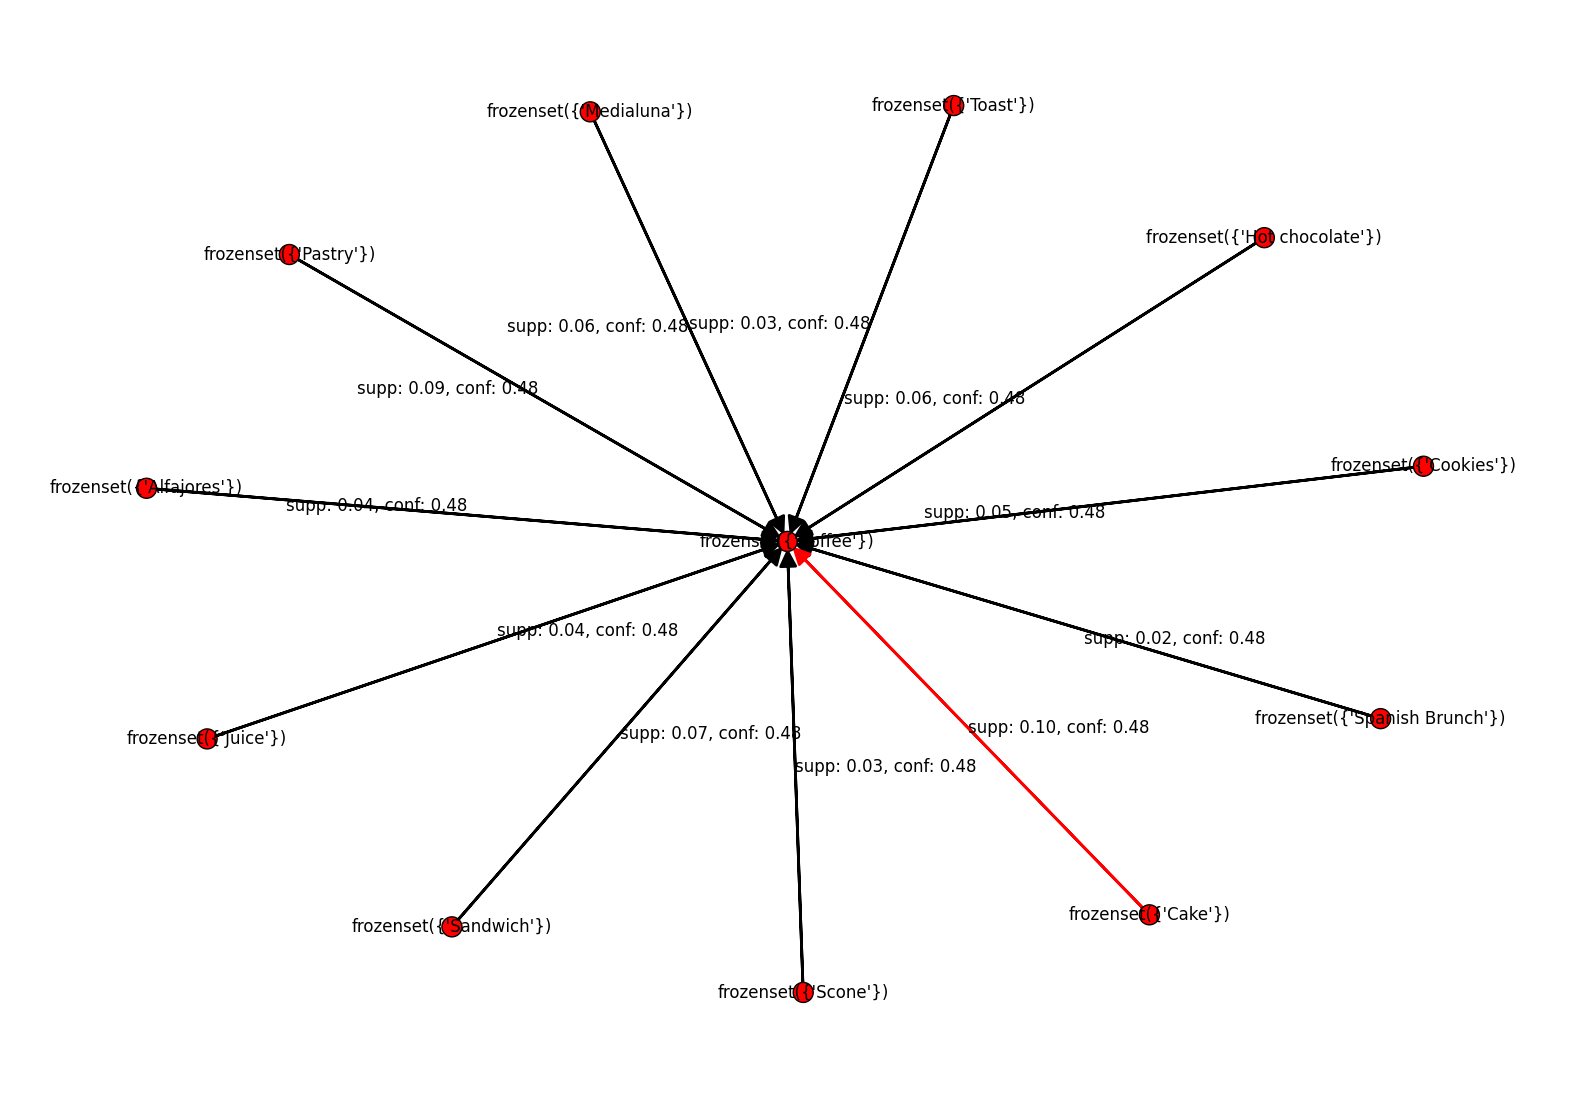

In [25]:
pip install python-igraph
import igraph as ig
# Filter rules with confidence > 0.5
filtered_rules = rules[rules['confidence'] > 0.5]

# Create an igraph graph from the filtered DataFrame
g = ig.Graph.TupleList(filtered_rules.itertuples(index=False), directed=True, 
                       edge_attrs=['support', 'confidence'])

# Identify the top 3 support values
top_support_indices = filtered_rules.nlargest(3, 'support').index

# Map the DataFrame indices to graph edge indices
edge_indices = [i for i, edge in enumerate(g.es) if edge.index in top_support_indices]

# Plotting the graph
layout = g.layout("kk")  # Kamada-Kawai layout
fig, ax = plt.subplots(figsize=(20, 14))

# Draw the graph with labels
visual_style = {
    "vertex_label": g.vs["name"],
    "edge_label": [(f"supp: {edge['support']:.2f}, conf: {edge['confidence']:.2f}") for edge in g.es],
    "layout": layout,
    "target": ax,
    "vertex_size": 20,
    "bbox": (700, 500),
    "edge_color": ["red" if i in edge_indices else "black" for i in range(len(g.es))]
}

ig.plot(g, **visual_style)
plt.show()